In [13]:
import stockdatalib as sd
from IPython.display import display
from IPython.display import HTML
import pandas as pd
import datetime as datetime
import numpy as np
import matplotlib.pyplot as plt

def plot_stock_charts():
    stock_title = sd.stock.upper() + ' ' + '(' + company_name + ')' + ' [' + company_sector + ' Sector]'
    price_df = sd.GetStockDataFrame(sd.stock)
    mean_1 = price_df['AdjClose'].rolling(window=100).mean()
    mean_1_name = '100d Mov.Ave.'
    mean_1_df = pd.DataFrame({'Timestamps': price_df['Timestamps'].to_list(), mean_1_name: mean_1})
    price_df = pd.merge(price_df, mean_1_df, on='Timestamps')

    fig = plt.figure(figsize=(15, 6))

    # ***************************************************
    # Find the full trend line
    x = range(len(price_df['Timestamps']))
    fit = np.polyfit(x, price_df['AdjClose'].astype(float), 1)
    fit_fn = np.poly1d(fit)
    print(fit_fn)

    trend = []
    for k in x:
        t = fit_fn(k)
        trend.append(t)
    price_df['5 Yr Trend'] = trend
    # ***************************************************

    twoyears_ago = datetime.datetime.today() - datetime.timedelta(days=2 * 365)
    price_df_2y = price_df[price_df['Timestamps'] > twoyears_ago].copy(deep=True)
    # price_df = price_df_2y
    # Find the 2 years trend line
    x = range(len(price_df_2y['Timestamps']))
    fit = np.polyfit(x, price_df_2y['AdjClose'].astype(float), 1)
    fit_fn = np.poly1d(fit)
    print(fit_fn)

    trend = []
    for k in x:
        t = fit_fn(k)
        trend.append(t)
    price_df_2y['2 Yr Trend'] = trend
    # ***************************************************

    oneyears_ago = datetime.datetime.today() - datetime.timedelta(days=1 * 365)
    price_df_1y = price_df[price_df['Timestamps'] > oneyears_ago].copy(deep=True)
    # Find the 1 year trend line
    x = range(len(price_df_1y['Timestamps']))
    fit = np.polyfit(x, price_df_1y['AdjClose'].astype(float), 1)
    fit_fn = np.poly1d(fit)
    print(fit_fn)

    trend = []
    for k in x:
        t = fit_fn(k)
        trend.append(t)
    price_df_1y['1 Yr Trend'] = trend
    # ***************************************************

    sixmonth_ago = datetime.datetime.today() - datetime.timedelta(days=0.5 * 365)
    price_df_6m = price_df[price_df['Timestamps'] > sixmonth_ago].copy(deep=True)
    # Find the 6 months trend line
    x = range(len(price_df_6m['Timestamps']))
    fit = np.polyfit(x, price_df_6m['AdjClose'].astype(float), 1)
    fit_fn = np.poly1d(fit)
    print(fit_fn)

    trend = []
    for k in x:
        t = fit_fn(k)
        trend.append(t)
    price_df_6m['6 Month Trend'] = trend
    # ***************************************************

    ts = pd.to_datetime(str(price_df['Timestamps'].iloc[0]))
    frm = ts.strftime('%Y-%m-%d')
    ts = pd.to_datetime(str(price_df['Timestamps'].iloc[-1]))
    to = ts.strftime('%Y-%m-%d')

    stock_title = stock_title + '\nFrom ' + frm \
                  + ' To ' + to

    fig, axs = plt.subplots(3, figsize=(15, 20), sharex=True, gridspec_kw={'hspace': 0, 'wspace': 0})
    fig.suptitle(stock_title, fontsize=30)

    price_df.plot(ax=axs[0], x='Timestamps', y=['Low', 'AdjClose', mean_1_name, 'High', '5 Yr Trend'],
                  title=stock_title)
    price_df_2y.plot(ax=axs[0], x='Timestamps', y=['2 Yr Trend'])
    price_df_1y.plot(ax=axs[0], x='Timestamps', y=['1 Yr Trend'])
    price_df_6m.plot(ax=axs[0], x='Timestamps', y=['6 Month Trend'], grid=True)

    # earn_df =

    dic = [{}]
    p_over_e_df = [{}]  # pd.DataFrame(columns=['Timestamps','Price/Earning'])

    i = 0
    main_df['EPS'] = sd.MakeFund_Subset(main_df_org['income-statement'], ['EPS'])
    main_df['PE ratio'] = sd.MakeFund_Subset(main_df_org['company-key-metrics'], ['PE ratio'])

    from_date = main_df['EPS'].index[i]

    to_date = main_df['EPS'].index[i + 1]
    for d in price_df['Timestamps']:
        if d > to_date:
            i = i + 1
            if i < len(main_df['EPS']) - 1:
                from_date = main_df['EPS'].index[i]
                to_date = main_df['EPS'].index[i + 1]
                continue
            else:
                break

        elif from_date <= d <= to_date:
            jj = main_df[main_df.index == from_date]['EPS'][0]
            pp = main_df[main_df.index == from_date]['PE ratio'][0]

            kk = price_df[price_df['Timestamps'] == d]['AdjClose'].values[0]

            dic.append({'Timestamps': d, 'Calc. P/E': (kk / jj) / 4.0, 'EPS': jj, 'P/E': pp})

        else:
            continue

    p_over_e_df = pd.DataFrame(dic).set_index('Timestamps').dropna()

    p_over_e_df.plot(ax=axs[1], y=['EPS'], grid=True)
    p_over_e_df.plot(ax=axs[2], y=['P/E'], grid=True)
    p_over_e_df.plot(ax=axs[2], y=['Calc. P/E'], grid=True)

In [4]:
# Set the data directory and the stock name
sd.set_data_directory('./data/')
sd.set_stock('aapl')

# Load S&P Stock list
stock_count, stock_fields, sp_df = sd.GetSP500_List()

# Get stock company information
stock_info = sp_df[sp_df.Symbol == sd.stock.upper()]
company_name = stock_info['Name'].iloc[0]
company_sector = stock_info['Sector'].iloc[0]


# Load stock End of Day prices file
price_df = sd.GetStockDataFrame(sd.stock)
# Index the data frame by 'Timestamps' column
price_df.set_index('Timestamps',inplace=True)

# Load the stock fundamental data
keys, column_map, main_df_org = sd.GetFund_Dict(sd.stock)

# Search for a key word in the data column names
f,s = sd.where_is_column('Revenue')
#display(f.to_html())

# Limit the stock prices data in the dates range
price_df = sd.df_start_after_datetime(price_df, '2015-01-01','2016-06-01')

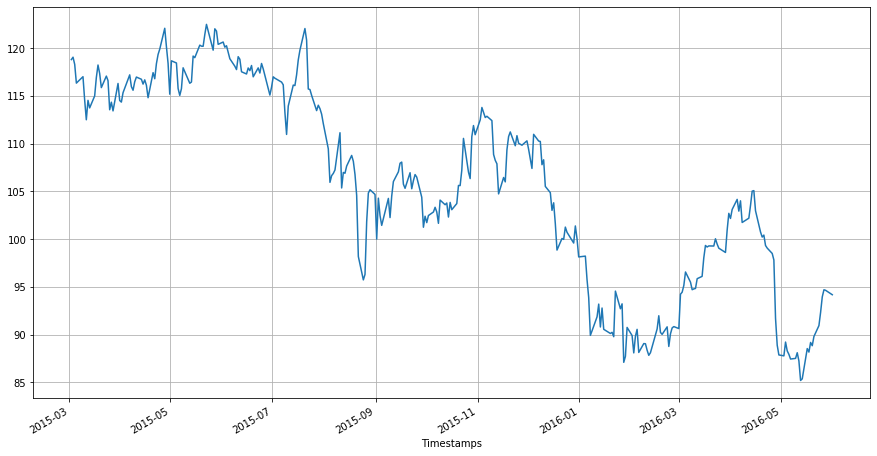

In [10]:
# Limit the stock prices data in the dates range
price_df = sd.df_start_after_datetime(price_df, '2015-01-01','2016-06-01')

# Plot the prices chart
price_df['AdjClose'].plot(figsize=(15,8)).grid()

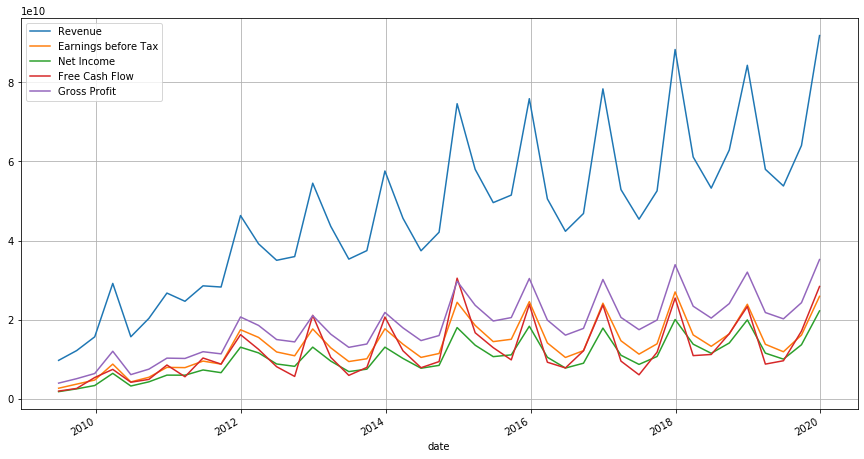

In [7]:
# Create a subset of columns in a DataFrame from the stock fundamentals dataset
cols = ['Revenue','Earnings before Tax','Net Income','Free Cash Flow margin','Gross Profit','Net Profit Margin'] # [ 'Shares', 'Price', 'Revenue', 'Earnings']
main_df1 = sd.MakeFund_Subset(main_df_org['income-statement'],cols)

# Create another subset of columns from another fundamentals dataset
cols = ['Number of Shares','Stock Price']
main_df2 = sd.MakeFund_Subset(main_df_org['enterprise-value'],cols)

# Create a 3rd subject of columns from yet another fundamentals dataset
cols = ['Capital Expenditure','Free Cash Flow']
main_df3 = sd.MakeFund_Subset(main_df_org['cash-flow-statement'],cols)

# Merge the 3 dataframes into a single dataframe
main_df = pd.merge(main_df1,main_df2,on='date')
main_df = pd.merge(main_df,main_df3,on='date')

main_df.plot(y=['Revenue','Earnings before Tax','Net Income','Free Cash Flow','Gross Profit'],figsize=(15,8)).grid()

 
0.1295 x + 74.05
 
0.2103 x + 154.5
 
0.5768 x + 158.7
 
0.9778 x + 207.6


<Figure size 1080x432 with 0 Axes>

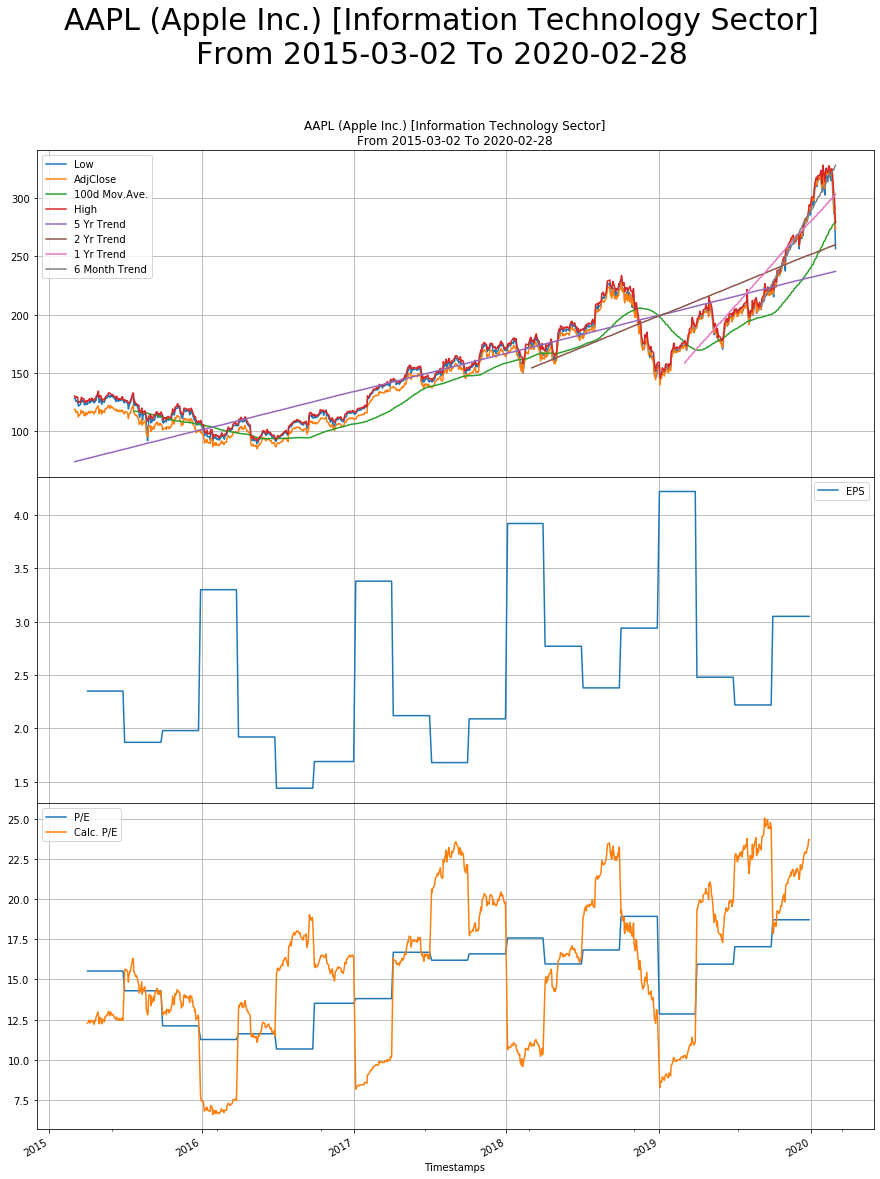

In [11]:
# Plot price chart with trend lines, EPS, and PE ratios
plot_stock_charts()

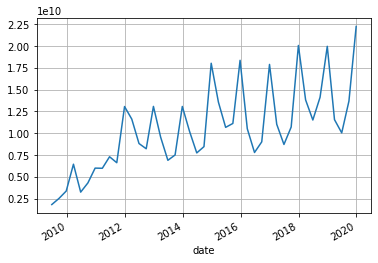

In [8]:

main_df['Net Income'].plot().grid()

The biggest +ve change in % price happend on 2018-05-04. Price changed by 13.25%
The biggest -ve change in % price happend on 2020-02-27. Price changed by -14.61%
The biggest +ve change in % volumne happend on 2016-01-04. Volume changed by 398.51%
The biggest -ve change in % volumne happend on 2017-02-08. Volume changed by -79.46%


,Open,High,Low,AdjClose,Volume,Price $ Change from 5 days ago,Price % Change from 5 days ago,Volume % Change from 5 days ago,5 Yr Trend,2 Yr Trend,1 Yr Trend,6 Month Trend
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1254.000000,1254.000000,1254.000000,1259.000000,502.000000,251.000000,124.000000
mean,160.495409,161.946084,159.125012,155.509658,3.511146e+07,0.667324,0.411874,11.206147,155.509658,207.203455,230.751857,267.687334
std,51.365519,51.931021,50.951578,53.418549,1.710817e+07,5.806318,3.426031,56.987573,47.089567,30.512013,41.877458,35.140824
min,90.000000,91.669998,89.470001,85.192909,1.136200e+07,-46.779999,-14.605058,-79.457874,74.045265,154.512829,158.650438,207.554478
25%,116.494999,117.410000,115.614998,109.802921,2.372490e+07,-2.060644,-1.464584,-23.113993,114.777461,180.858142,194.701147,237.620906
50%,154.699997,155.800003,153.330002,149.842514,3.099190e+07,0.863407,0.656293,-1.807415,155.509658,207.203455,230.751857,267.687334
75%,189.955002,191.775002,188.459999,186.291611,4.152810e+07,3.611080,2.412439,31.315296,196.241854,233.548768,266.802566,297.753762
max,324.739990,327.850006,323.350006,327.200012,1.622063e+08,20.913635,13.251601,398.507045,236.974051,259.894080,302.853276,327.820190


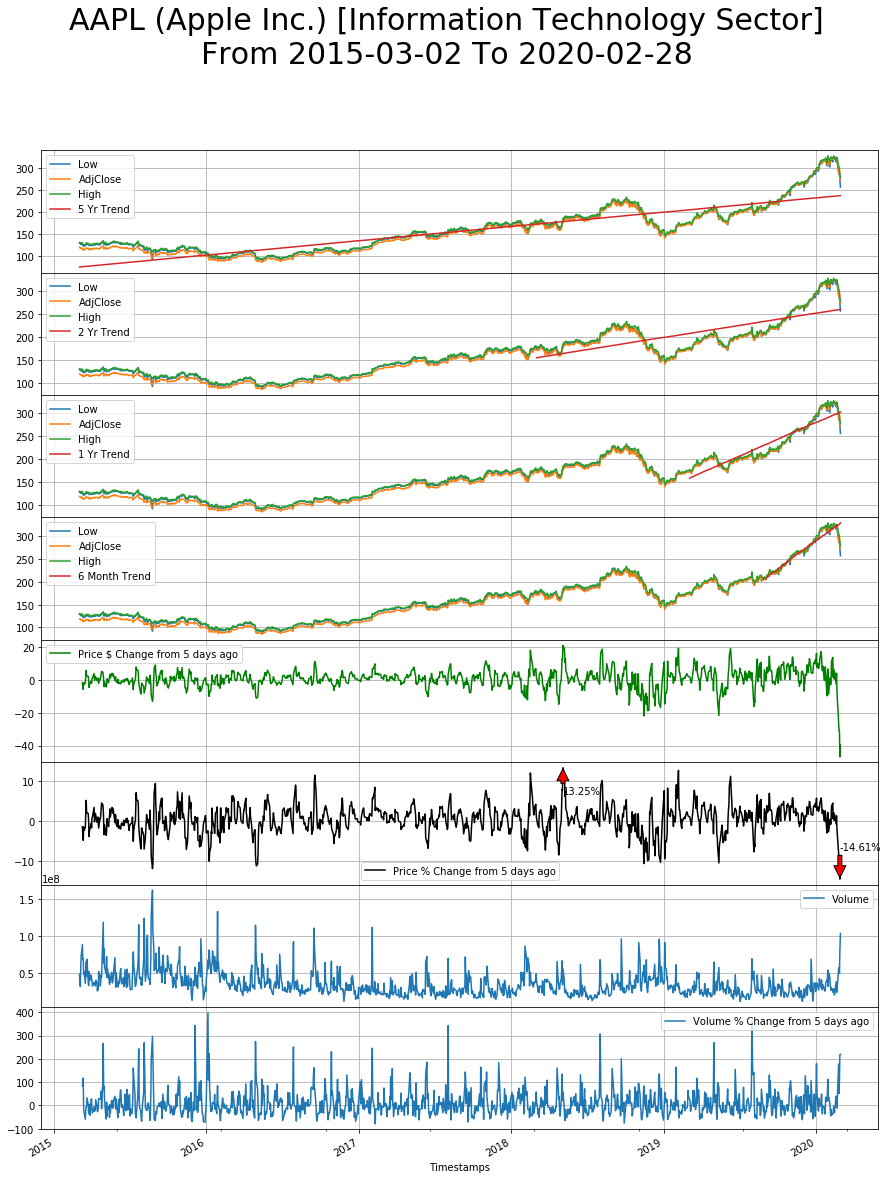

In [31]:
import time
price_data_df = price_df.copy(deep=True)
dif_period = 5

# Load stock End of Day prices file
price_data_df = sd.GetStockDataFrame(sd.stock)

price_change = 'Price $ Change from '+str(dif_period)+' days ago'
price_data_df[price_change] = price_df['AdjClose'].diff(dif_period).astype(float)

price_change_percent = 'Price % Change from '+str(dif_period)+' days ago'
price_data_df[price_change_percent] = price_df['AdjClose'].pct_change(dif_period).astype(float) * 100

volume_change_percent = 'Volume % Change from '+str(dif_period)+' days ago'
price_data_df[volume_change_percent] = price_df['Volume'].pct_change(dif_period).astype(float) * 100


# ***************************************************
# Find the full trend line
x = range(len(price_data_df['Timestamps']))
fit = np.polyfit(x, price_data_df['AdjClose'].astype(float), 1)
fit_fn = np.poly1d(fit)
trend = []
for k in x:
    t = fit_fn(k)
    trend.append(t)
price_data_df['5 Yr Trend'] = trend
# ***************************************************

twoyears_ago = datetime.datetime.today() - datetime.timedelta(days=2 * 365)
price_df_2y = price_data_df[price_data_df['Timestamps'] > twoyears_ago].copy(deep=True)
# price_data_df = price_df_2y
# Find the 2 years trend line
x = range(len(price_df_2y['Timestamps']))
fit = np.polyfit(x, price_df_2y['AdjClose'].astype(float), 1)
fit_fn = np.poly1d(fit)
trend = []
for k in x:
    t = fit_fn(k)
    trend.append(t)
price_df_2y['2 Yr Trend'] = trend
# ***************************************************

oneyears_ago = datetime.datetime.today() - datetime.timedelta(days=1 * 365)
price_df_1y = price_data_df[price_data_df['Timestamps'] > oneyears_ago].copy(deep=True)
# Find the 1 year trend line
x = range(len(price_df_1y['Timestamps']))
fit = np.polyfit(x, price_df_1y['AdjClose'].astype(float), 1)
fit_fn = np.poly1d(fit)
trend = []
for k in x:
    t = fit_fn(k)
    trend.append(t)
price_df_1y['1 Yr Trend'] = trend
# ***************************************************

sixmonth_ago = datetime.datetime.today() - datetime.timedelta(days=0.5 * 365)
price_df_6m = price_data_df[price_data_df['Timestamps'] > sixmonth_ago].copy(deep=True)
# Find the 6 months trend line
x = range(len(price_df_6m['Timestamps']))
fit = np.polyfit(x, price_df_6m['AdjClose'].astype(float), 1)
fit_fn = np.poly1d(fit)
trend = []
for k in x:
    t = fit_fn(k)
    trend.append(t)
price_df_6m['6 Month Trend'] = trend
# ***************************************************

stock_title = sd.stock.upper()+ ' ' +'('+company_name+')'+' ['+ company_sector+' Sector]'
ts = pd.to_datetime(str(price_data_df['Timestamps'].iloc[0])) 
frm = ts.strftime('%Y-%m-%d')
ts = pd.to_datetime(str(price_data_df['Timestamps'].iloc[-1])) 
to = ts.strftime('%Y-%m-%d')

stock_title = stock_title + '\nFrom '+ frm \
                        + ' To ' + to

price_data_df['2 Yr Trend'] = price_df_2y['2 Yr Trend'].copy(deep=True)
price_data_df['1 Yr Trend'] = price_df_1y['1 Yr Trend'].copy(deep=True)
price_data_df['6 Month Trend'] = price_df_6m['6 Month Trend'].copy(deep=True)

price_data_df.set_index('Timestamps', inplace=True)

fig, axs = plt.subplots(8,figsize=(15,20), sharex = True , gridspec_kw={'hspace': 0, 'wspace': 0})
fig.suptitle(stock_title, fontsize=30) 

price_data_df.plot(ax=axs[0],y=['Low','AdjClose','High','5 Yr Trend'], grid=True)
price_data_df.plot(ax=axs[1],y=['Low','AdjClose','High','2 Yr Trend'], grid=True)
price_data_df.plot(ax=axs[2],y=['Low','AdjClose','High','1 Yr Trend'], grid=True)
price_data_df.plot(ax=axs[3],y=['Low','AdjClose','High','6 Month Trend'], grid=True)
price_data_df.plot(ax=axs[4],y=[price_change], grid=True, color='green')
price_data_df.plot(ax=axs[5],y=[price_change_percent], grid=True, color='black')
price_data_df.plot(ax=axs[6],y=['Volume'], grid=True)
price_data_df.plot(ax=axs[7],y=[volume_change_percent], grid=True)

# Find Max and Min for price and volume changes and mark price max and min on chart
max_price_change = price_data_df[ np.round(price_data_df[price_change_percent],2) 
                                 == np.round(price_data_df[price_change_percent].max(),2)]
min_price_change = price_data_df[ np.round(price_data_df[price_change_percent],2) 
                                 == np.round(price_data_df[price_change_percent].min(),2)]

max_vol_change = price_data_df[ price_data_df[volume_change_percent] 
                               == price_data_df[volume_change_percent].max()]
min_vol_change = price_data_df[ price_data_df[volume_change_percent] 
                               == price_data_df[volume_change_percent].min()]


# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

ts = pd.to_datetime(str(max_price_change.index.values[0])) 
mxp = ts.strftime('%Y-%m-%d')

ts = pd.to_datetime(str(min_price_change.index.values[0])) 
mnp = ts.strftime('%Y-%m-%d')

print('The biggest +ve change in % price happend on', mxp+'.', 'Price changed by',
      str(np.round(max_price_change[price_change_percent].values[0],2))+'%')    
print('The biggest -ve change in % price happend on', mnp+'.', 'Price changed by',
      str(np.round(min_price_change[price_change_percent].values[0],2))+'%')

ts = pd.to_datetime(str(max_vol_change.index.values[0])) 
mxv = ts.strftime('%Y-%m-%d')

# Annotate charts with max and min
axs[5].annotate(str(np.round(max_price_change[price_change_percent].values[0],2))+'%', 
                xy=(max_price_change.index.values[0],                                   
                max_price_change[price_change_percent].values[0]), 
                xytext=(max_price_change.index.values[0], 
                max_price_change[price_change_percent].values[0] * 0.5),
                arrowprops=dict(facecolor='red', shrink=0.05),
                )


ts = pd.to_datetime(str(min_vol_change.index.values[0])) 
mnv = ts.strftime('%Y-%m-%d')
axs[5].annotate(str(np.round(min_price_change[price_change_percent].values[0],2))+'%', 
                xy=(min_price_change.index.values[0],                                   
                min_price_change[price_change_percent].values[0]), 
                xytext=(min_price_change.index.values[0], 
                min_price_change[price_change_percent].values[0] * 0.5),
                arrowprops=dict(facecolor='red', shrink=0.05),
                )

print('The biggest +ve change in % volumne happend on', mxv+'.', 'Volume changed by', 
      str(np.round(max_vol_change[volume_change_percent].values[0],2))+'%')
print('The biggest -ve change in % volumne happend on', mnv+'.', 'Volume changed by', 
      str(np.round(min_vol_change[volume_change_percent].values[0],2))+'%')

price_data_df.describe()